# Style transfer using VGG19 network

* `A Neural Algorithm of Artistic Style`, [arXiv:1508.06576](https://arxiv.org/abs/1508.06576)
  * Leon A. Gatys, Alexander S. Ecker, and, Matthias Bethge


* VGG19 model code is borrowed from `models/research/slim/nets` and is modified (`max_pool` -> `avg_pool`)
* Set the max length of content_input_image: 1024 (changeable for the purpose)
* Set the max length of style_input_image: 1024 (changeable for the purpose)
* Use `average_pooling` from original paper
* Use the loss from Johnson's paper
  * Johnson et., al. Perceptual Losses for Real-Time Style Transfer and Super-Resolution 
  * Normalize to the number of elements of feature maps for both content loss and style loss, respectively
* Hyperparameters are borrowed from [cs20](http://web.stanford.edu/class/cs20si/) class and [TensorFlow official page](https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb)
* input_image
  * my cats
  * tubingen (this image is borrowed from [https://github.com/jcjohnson/neural-style](https://github.com/jcjohnson/neural-style))
* style_image
  * [Starry Night](https://en.wikipedia.org/wiki/The_Starry_Night) [Gogh's painting]
  * [The Scream](https://en.wikipedia.org/wiki/The_Scream) [Munch's painting]

## Import

In [1]:
#import sys
#sys.path.append("$HOME/models/research/slim/")

import os
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyperparameters setting

In [2]:
input_data_dir = '../input_data/'
content_image_name = 'tubingen.jpg'
style_image_name = 'Gogh_The_Starry_Night.jpg'
#style_image_name = 'Munch_The_Scream.jpg'
noise_ratio = 0.5
content_image_max_L = 512 # upper bound of content image size
style_image_max_L = 512 # upper bound of style image size
style_loss_weight = np.array([0.5, 1.0, 1.5, 3.0, 4.0])
#style_loss_weight = np.array([1, 1, 1, 1, 1], dtype=np.float32)
style_loss_weight /= np.sum(style_loss_weight)
content_weight = 1.0
style_weight = 0.01
tv_weight = 1e-4
learning_rate = 5.0
max_steps = 500
print_steps = 50

### Load a VGG19 graph

In [3]:
def vgg_19(inputs,
           reuse=False,
           scope='vgg_19'):
  """Oxford Net VGG 19-Layers version E Example
  
  My Note: This code is modified version of vgg_19 which is loacted on `models/research/slim/nets/vgg.py`
  Note: All the fully_connected layers have been transformed to conv2d layers.
        To use in classification mode, resize input to 224x224.

  Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    reuse: whether or not the model is being reused.
    scope: Optional scope for the variables.

  Returns:
    net: the output of the logits layer (if num_classes is a non-zero integer),
      or the input to the logits layer (if num_classes is 0 or None).
    end_points: a dict of tensors with intermediate activations.
  """
  with tf.variable_scope(scope, 'vgg_19', [inputs], reuse=reuse) as sc:
    end_points_collection = sc.original_name_scope + '_end_points'
    with slim.arg_scope([slim.conv2d, slim.avg_pool2d],
                        outputs_collections=end_points_collection):
      net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
      net = slim.avg_pool2d(net, [2, 2], scope='pool1')
      net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
      net = slim.avg_pool2d(net, [2, 2], scope='pool2')
      net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3')
      net = slim.avg_pool2d(net, [2, 2], scope='pool3')
      net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4')
      net = slim.avg_pool2d(net, [2, 2], scope='pool4')
      net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv5')
      #net = slim.avg_pool2d(net, [2, 2], scope='pool5')

      end_points = slim.utils.convert_collection_to_dict(end_points_collection)

      return net, end_points

### Read content image and style image

In [4]:
content_image_ = Image.open(os.path.join(input_data_dir, content_image_name))
style_image_ = Image.open(os.path.join(input_data_dir, style_image_name))

In [5]:
def image_resize_to_upper_bound(image, max_L=None):
  """Resize images
  
  Args:
    image: PIL image format
    max_L: upper bound of the image size
    
  Returns:
    image: resized image with PIL format
    h: resized height
    w: resized width
  """
  w, h = image.size
  if max_L is not None:
    if h < w:
      h = int(max_L * h / w)
      w = max_L
    else:
      w = int(max_L * w / h)
      h = max_L
    image = image.resize((w, h), Image.ANTIALIAS)
  
  return image, h, w

#### Resize images

In [6]:
content_image_, content_image_h, \
content_image_w = image_resize_to_upper_bound(content_image_, content_image_max_L)
style_image_, style_image_h, \
style_image_w = image_resize_to_upper_bound(style_image_, style_image_max_L)
print('content_image size: height: {}  width: {}'.format(content_image_h, content_image_w))
print('style_image size: height: {}  width: {}'.format(style_image_h, style_image_w))

content_image size: height: 384  width: 512
style_image size: height: 405  width: 512


## Create `tf.placeholder`s and `tf.Variable`s

In [7]:
content_image_p = tf.placeholder(tf.float32, [1, content_image_h, content_image_w, 3])
style_image_p = tf.placeholder(tf.float32, [1, style_image_h, style_image_w, 3])

# Set the zero tensors to change from tf.placeholder to tf.Variable for content_image and style_image
content_image = tf.get_variable(name='content_image',
                                shape=[1, content_image_h, content_image_w, 3],
                                initializer=tf.zeros_initializer())
style_image = tf.get_variable(name='style_image',
                              shape=[1, style_image_h, style_image_w, 3],
                              initializer=tf.zeros_initializer())
# Set the random noise tensor with same shape of content_image for generated_iamge
generated_image = tf.get_variable(name='generated_image',
                                  shape=[1, content_image_h, content_image_w, 3],
                                  initializer=tf.random_uniform_initializer(minval=107,
                                                                            maxval=147))
# vgg preprocessing by mean_image_subtraction
# Chnage from tf.placeholder to tf.Variable
norm_means = np.array([123.68, 116.779, 103.939])
content_image_op = content_image.assign(content_image_p - norm_means)
style_image_op = style_image.assign(style_image_p - norm_means)
# Initial image is a mixture of content_image and random noise tensor
initial_image_op = generated_image.assign(generated_image * noise_ratio + \
                                          content_image_p * (1.0 - noise_ratio))

vgg_preprocessing_op = generated_image.assign(generated_image - norm_means)

# Clipping generated_image by below values in every iteration
min_vals = -norm_means
max_vals = 255. - norm_means
generated_image_clipping = generated_image.assign(tf.clip_by_value(generated_image,
                                                                   clip_value_min=min_vals,
                                                                   clip_value_max=max_vals))

### Calculate feature maps

In [8]:
_, feature_maps_c = vgg_19(content_image) # input: content_image
_, feature_maps_s = vgg_19(style_image, reuse=True) # input: style_image
_, feature_maps_g = vgg_19(generated_image, reuse=True) # input: generated_image

In [9]:
with tf.Session() as sess:
  writer = tf.summary.FileWriter("../graphs/01_style_transfer", sess.graph)
  writer.close()

## Build a model

### collecte feature maps

* content layers
  * `conv4_2`: key name -> 'vgg_19/conv4/conv4_2'
* style layers
  * `conv1_1`: key name -> 'vgg_19/conv1/conv1_1'
  * `conv2_1`: key name -> 'vgg_19/conv2/conv2_1'
  * `conv3_1`: key name -> 'vgg_19/conv3/conv3_1'
  * `conv4_1`: key name -> 'vgg_19/conv4/conv4_1'
  * `conv5_1`: key name -> 'vgg_19/conv5/conv5_1'

In [10]:
content_layers = feature_maps_c['vgg_19/conv4/conv4_2']
style_layers = [feature_maps_s['vgg_19/conv1/conv1_1'],
                feature_maps_s['vgg_19/conv2/conv2_1'],
                feature_maps_s['vgg_19/conv3/conv3_1'],
                feature_maps_s['vgg_19/conv4/conv4_1'],
                feature_maps_s['vgg_19/conv5/conv5_1']]
generated_layers = [feature_maps_g['vgg_19/conv4/conv4_2'],
                    feature_maps_g['vgg_19/conv1/conv1_1'],
                    feature_maps_g['vgg_19/conv2/conv2_1'],
                    feature_maps_g['vgg_19/conv3/conv3_1'],
                    feature_maps_g['vgg_19/conv4/conv4_1'],
                    feature_maps_g['vgg_19/conv5/conv5_1']]

### content loss

In [11]:
def content_loss(P, F, scope):
  """Calculate the content loss function between
  the feature maps of content image and generated image.
  
  Args:
    P: the feature maps of the content image
    F: the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: content loss (mean squared loss)
  """
  with tf.variable_scope(scope):
    assert F.shape == P.shape
    loss = tf.losses.mean_squared_error(F, P)
    #loss = 0.5 * tf.reduce_sum(tf.square(F - P)) # original loss on paper
  return loss

### style loss

In [12]:
def style_loss(style_layers, generated_layers, scope):
  """Calculate the style loss function between
  the gram matrix of feature maps of style image and generated image.
  
  Args:
    style_layers: list of the feature maps of the style image
    generated_layers: list of the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: style loss (mean squared loss)
  """
  def _style_loss_one_layer(feature_map_s, feature_map_g):
    """Calculate the style loss for one layer.
    
    Args:
      feature_map_s: the feature map of the style image
        - G: the gram matrix of the feature_map_s
      feature_map_g: the feature map of the generated image
        - A: the gram matrix of the feature_map_g
      
    Returns:
      loss: style loss for one layer (mean squared loss)
    """
    G = _gram_matrix(feature_map_s)
    A = _gram_matrix(feature_map_g)
    loss = tf.losses.mean_squared_error(G, A)
    return loss
  
  def _gram_matrix(feature_map):
    """Calculate the gram matrix for the feature map
    
    Args:
      feature_map: 4-rank Tensor [1, height, width, channels]
        - F = 2-rank Tensor [h * w, channels]
      
    Returns:
      gram_matrix: 2-rank Tensor [c, c] (F.transpose x F)
    """
    F = tf.squeeze(feature_map, axis=0)
    h, w, c = F.get_shape().as_list()
    F = tf.reshape(F, [h * w, c])
    # normalize for calculating squared Frobenius norm
    gram_matrix = tf.matmul(tf.transpose(F), F) / (h * w)
    return gram_matrix
    
  with tf.variable_scope(scope):
    assert len(style_layers) == len(generated_layers)
  
    loss = 0.0
    for i in range(len(style_layers)):
      loss_one = _style_loss_one_layer(style_layers[i], generated_layers[i])
      loss += loss_one * style_loss_weight[i]

  return loss

### Total loss

In [13]:
loss_c = content_loss(content_layers, generated_layers[0],
                      scope='content_loss') * content_weight
loss_s = style_loss(style_layers, generated_layers[1:],
                    scope='style_loss') * style_weight
total_variation = tf.squeeze(tf.image.total_variation(generated_image),
                             name='total_variation') * tv_weight

with tf.variable_scope('total_loss'):
  total_loss = loss_c + loss_s + total_variation

### Define a optimizer

In [14]:
#opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.99, epsilon=1e-1)
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = opt.minimize(total_loss, var_list=generated_image)

### Restore VGG16 weights using `tf.saver.restore`

### Download the VGG19 checkpoint: 

```
$ CHECKPOINT_DIR='../checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/vgg_19_2016_08_28.tar.gz
$ tar -xvf vgg_19_2016_08_28.tar.gz
$ mv vgg_19.ckpt ${CHECKPOINT_DIR}
$ rm vgg_19_2016_08_28.tar.gz
```

In [15]:
# Download the VGG19 checkpoint: 
# if you already have a vgg_19.ckpt then skip and comment below commands
#!mkdir ../checkpoints
#!wget http://download.tensorflow.org/models/vgg_19_2016_08_28.tar.gz
#!tar -xvf vgg_19_2016_08_28.tar.gz
#!mv vgg_19.ckpt ../checkpoints
#!rm vgg_19_2016_08_28.tar.gz
#print('done')

### Preprocessing a image

In [16]:
def preprocessing(image):
  """image preprocessing

  Args:
    image (PIL image): image with shape [height, width, channels]
    
  Returns:
    image (np.float32): numpy type 4-rank tensor shape [1, height, width, channels]
  """
  image = np.asarray(image)
  image = image.astype(np.float32)
  image = np.expand_dims(image, axis=0)
  
  return image

In [17]:
def deprocess_image(image):
  """vgg image deprocessing.
  
  Args:
    image (np.float32): 4-rank np.array [1, height, width, 3]
  
  Returns:
    image_ (np.uint8): image applied by mean_image_addition and cast type
  """
  image_ = copy.deepcopy(image)
  image_ = np.squeeze(image_, axis=0)
  image_[:, :, 0] += 123.68
  image_[:, :, 1] += 116.779
  image_[:, :, 2] += 103.939
  image_ = np.clip(image_, 0, 255).astype('uint8')
  
  return image_

In [18]:
def print_image(image):
  """print image
  
  Args:
    image (np.float32): 4-rank np.array [1, height, width, 3]
  """
  print_image = deprocess_image(image)
  plt.axis('off')
  plt.imshow(print_image)
  plt.show()

In [19]:
content_image_ = preprocessing(content_image_)
style_image_ = preprocessing(style_image_)

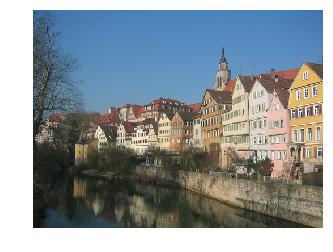

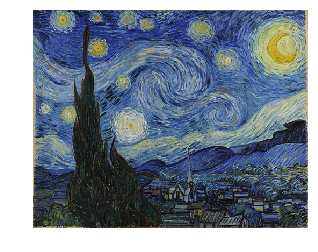

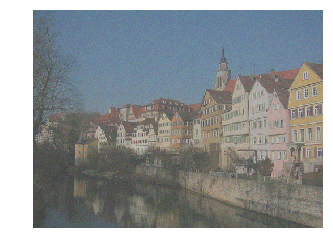

INFO:tensorflow:Restoring parameters from ../checkpoints/vgg_19.ckpt
step: 50  total_loss: 140757.640625  loss_c: 62905.18359375  loss_s: 75442.6953125  total_variation: 2409.76513671875  duration: 5.062723159790039


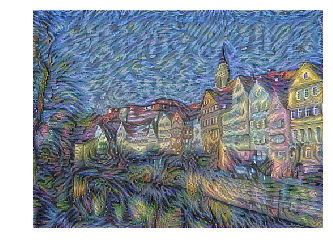

step: 100  total_loss: 92970.5  loss_c: 57148.6953125  loss_s: 33571.7578125  total_variation: 2250.04296875  duration: 2.956728219985962


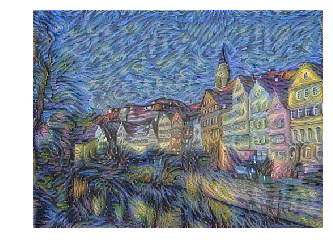

step: 150  total_loss: 77792.4375  loss_c: 53459.5625  loss_s: 22172.3828125  total_variation: 2160.494140625  duration: 2.97322940826416


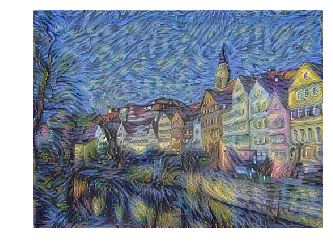

step: 200  total_loss: 69896.9140625  loss_c: 50887.07421875  loss_s: 16912.25  total_variation: 2097.583251953125  duration: 2.980172872543335


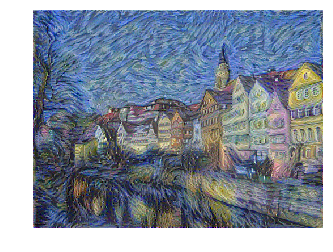

step: 250  total_loss: 65096.28515625  loss_c: 48993.82421875  loss_s: 14056.216796875  total_variation: 2046.2469482421875  duration: 2.9917447566986084


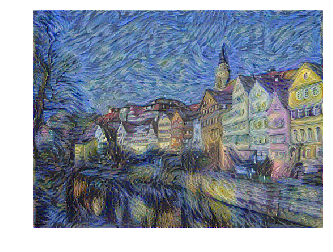

step: 300  total_loss: 61840.03125  loss_c: 47547.484375  loss_s: 12291.1845703125  total_variation: 2001.3638916015625  duration: 2.988462448120117


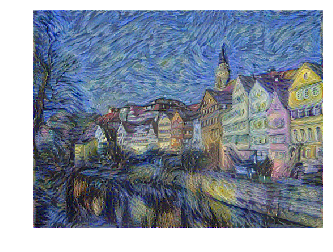

step: 350  total_loss: 60088.09765625  loss_c: 46671.375  loss_s: 11446.9736328125  total_variation: 1969.7515869140625  duration: 2.9970149993896484


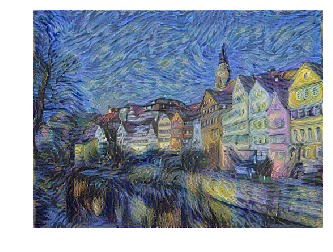

step: 400  total_loss: 57864.3671875  loss_c: 45624.0625  loss_s: 10311.2900390625  total_variation: 1929.0169677734375  duration: 2.993489980697632


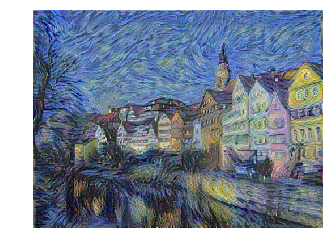

step: 450  total_loss: 62057.8828125  loss_c: 45652.171875  loss_s: 14505.99609375  total_variation: 1899.71630859375  duration: 2.994180679321289


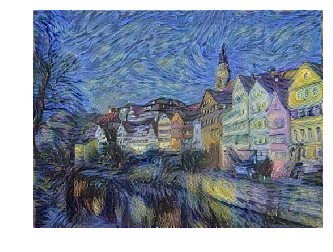

step: 500  total_loss: 55376.51953125  loss_c: 44322.8203125  loss_s: 9187.6015625  total_variation: 1866.095947265625  duration: 3.011434555053711


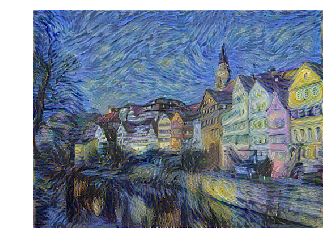

training done!


In [20]:
v = tf.get_collection(tf.GraphKeys.MODEL_VARIABLES, scope='vgg_19')
saver = tf.train.Saver(var_list=v)

with tf.Session(config=sess_config) as sess:
  sess.run(tf.global_variables_initializer())
  # Change from tf.placeholder to Variable for content_image_ and style_image_
  sess.run([content_image_op, style_image_op],
           feed_dict={content_image_p: content_image_,
                      style_image_p: style_image_})
  sess.run(initial_image_op, feed_dict={content_image_p: content_image_})
  sess.run(vgg_preprocessing_op)
  sess.run(generated_image_clipping)
  
  content_image_, style_image_, generated_image_ = sess.run([content_image,
                                                             style_image,
                                                             generated_image])
  print_image(content_image_)
  print_image(style_image_)
  print_image(generated_image_) # initial_image = content_image + small noise

  # use saver object to load variables from the saved model
  saver.restore(sess, "../checkpoints/vgg_19.ckpt")
  
  start_time = time.time()
  for step in range(max_steps):
    _, loss_, loss_c_, loss_s_, tv_, _ = \
        sess.run([train_op, total_loss,
                  loss_c, loss_s, total_variation,
                  generated_image_clipping])
    generated_image_ = sess.run(generated_image)
    if (step+1) % print_steps == 0:
      duration = time.time() - start_time
      print("step: {}  total_loss: {}  loss_c: {}  loss_s: {}  total_variation: {}  duration: {}".format((step+1), loss_, loss_c_, loss_s_, tv_, duration))
      print_image(generated_image_)
      start_time = time.time()
  print('training done!')

In [21]:
def save_image(image, content_image_name, style_image_name,
               style_weight, content_image_max_L, style_image_max_L,
               tv_weight):
  """save image
  
  Args:
    image (np.float32): 4-rank np.array [1, h, w, 3]
    content_image_name (string): filename of content image
    style_image_name (string): filename of style image
    style_weight (np.float32): weight of style loss
    content_image_max_L (np.int32): max length of content image
    style_image_max_L (np.int32): max length of style image
    tv_weight (np.float32): weight of total variation loss
  """
  save_image = deprocess_image(image)
  save_image = Image.fromarray(np.uint8(save_image))
  filename = os.path.splitext(os.path.basename(content_image_name))[0] + '_'
  filename += os.path.splitext(os.path.basename(style_image_name))[0] + '_'
  filename += 'sw_' + '%g' % (style_weight) + '_'
  if content_image_max_L is not None:
    filename += 'cs_' + '%d' % (content_image_max_L) + '_'
  else:
    filename += 'cs_0_'
  if style_image_max_L is not None:
    filename += 'ss_' + '%d' % (style_image_max_L) + '_'
  else:
    filename += 'ss_0_'
  filename += 'tv_' + '%g' % (tv_weight) + '.jpg'
  save_image.save(filename)

In [22]:
save_image(generated_image_, content_image_name, style_image_name,
           style_weight, content_image_max_L, style_image_max_L, tv_weight)